In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
uploaded = files.upload()
for fn in uploaded.keys():
    if fn.endswith(".json"):
        json_name = fn
!mv "$json_name" kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign -p /content
!unzip -o /content/gtsrb-german-traffic-sign.zip -d /content/gtsrb


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/gtsrb/train/5/00005_00053_00010.png  
  inflating: /content/gtsrb/train/5/00005_00053_00011.png  
  inflating: /content/gtsrb/train/5/00005_00053_00012.png  
  inflating: /content/gtsrb/train/5/00005_00053_00013.png  
  inflating: /content/gtsrb/train/5/00005_00053_00014.png  
  inflating: /content/gtsrb/train/5/00005_00053_00015.png  
  inflating: /content/gtsrb/train/5/00005_00053_00016.png  
  inflating: /content/gtsrb/train/5/00005_00053_00017.png  
  inflating: /content/gtsrb/train/5/00005_00053_00018.png  
  inflating: /content/gtsrb/train/5/00005_00053_00019.png  
  inflating: /content/gtsrb/train/5/00005_00053_00020.png  
  inflating: /content/gtsrb/train/5/00005_00053_00021.png  
  inflating: /content/gtsrb/train/5/00005_00053_00022.png  
  inflating: /content/gtsrb/train/5/00005_00053_00023.png  
  inflating: /content/gtsrb/train/5/00005_00053_00024.png  
  inflating: /content/gtsrb/trai

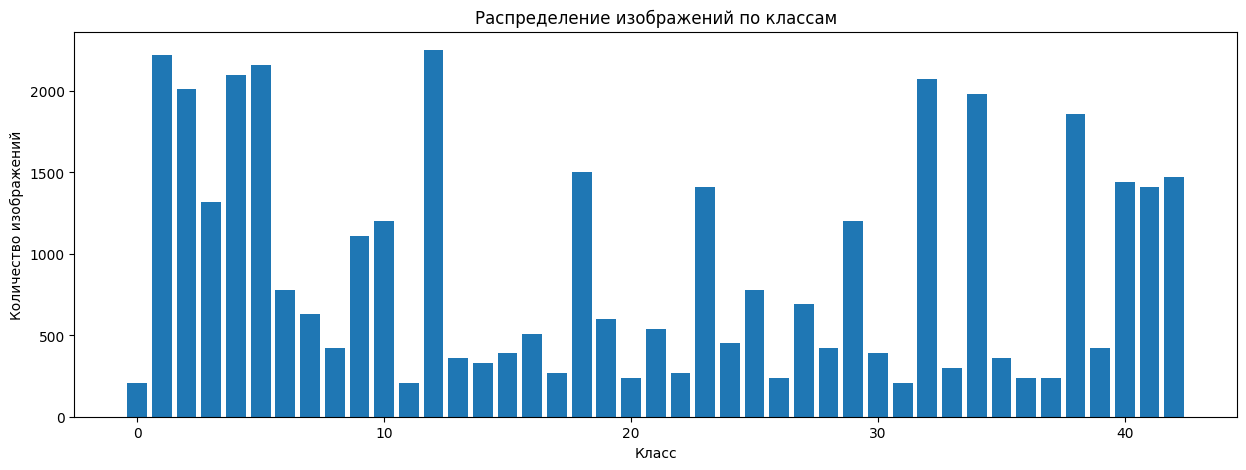

(39209, 43)

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

train_root = "/content/gtsrb/Train"

# Загружаем необработанный датасет без трансформаций
dataset_raw = datasets.ImageFolder(root=train_root, transform=None)

# Считаем количество изображений по каждому классу
class_counts = {}
for _, label in dataset_raw.samples:
    class_counts[label] = class_counts.get(label, 0) + 1

class_counts_sorted = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Визуализация распределения
plt.figure(figsize=(15,5))
plt.bar(class_counts_sorted.keys(), class_counts_sorted.values())
plt.title("Распределение изображений по классам")
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.show()

len(dataset_raw), len(class_counts_sorted)


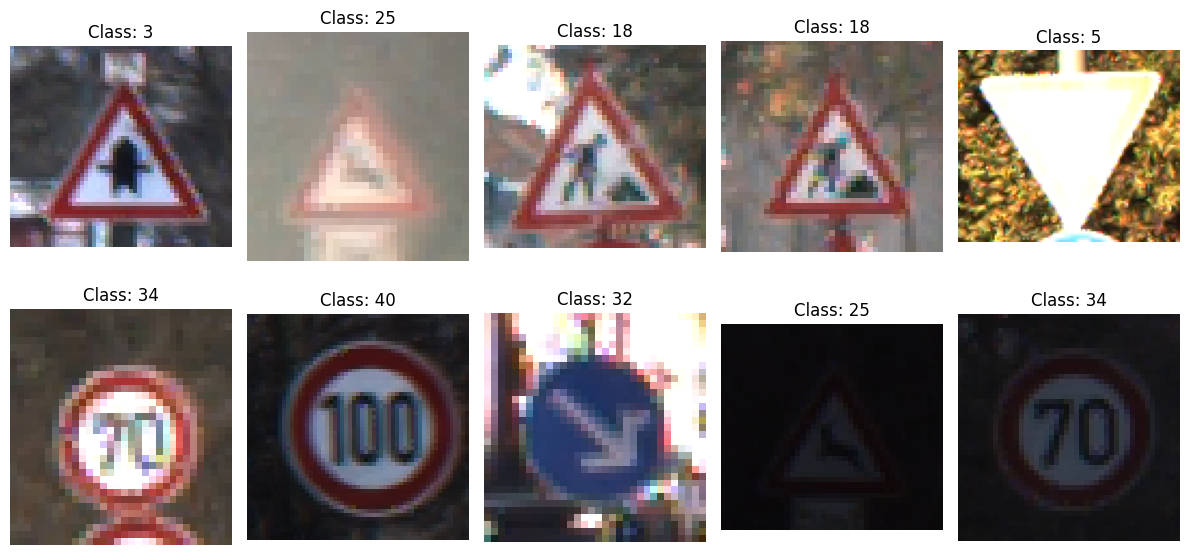

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
indices = np.random.choice(range(len(dataset_raw)), 10, replace=False)

for ax, idx in zip(axes.flatten(), indices):
    img, label = dataset_raw[idx]
    ax.imshow(img)
    ax.set_title(f"Class: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from torchvision import transforms

# Трансформации
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=5, translate=(0.02, 0.02), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Разбиение
total = len(dataset_raw)
train_size = int(total * 0.70)
val_size   = int(total * 0.15)
test_size  = total - train_size - val_size

generator = torch.Generator().manual_seed(42)
splits = random_split(dataset_raw, [train_size, val_size, test_size], generator=generator)

train_indices = splits[0].indices
val_indices   = splits[1].indices
test_indices  = splits[2].indices

# Создаём датасеты с трансформациями
dataset_train = datasets.ImageFolder(root=train_root, transform=train_transform)
dataset_val   = datasets.ImageFolder(root=train_root, transform=val_test_transform)
dataset_test  = datasets.ImageFolder(root=train_root, transform=val_test_transform)

train_dataset = Subset(dataset_train, train_indices)
val_dataset   = Subset(dataset_val, val_indices)
test_dataset  = Subset(dataset_test, test_indices)

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

len(train_dataset), len(val_dataset), len(test_dataset)


(27446, 5881, 5882)

In [ ]:
import os, shutil

original_test_dir = "/content/gtsrb/Test"
processed_test_dir = "/content/gtsrb/ProcessedTest"
os.makedirs(processed_test_dir, exist_ok=True)
df = pd.read_csv("/content/gtsrb/Test.csv", sep=',')
for class_id in range(43):
    os.makedirs(os.path.join(processed_test_dir, f"{class_id:02d}"), exist_ok=True)
copied = 0
missing = 0

for _, row in df.iterrows():
    filename = row["Path"].split("/")[-1]
    class_id = int(row["ClassId"])

    src = os.path.join(original_test_dir, filename)
    dst = os.path.join(processed_test_dir, f"{class_id:02d}", filename)

    if os.path.exists(src):
        if not os.path.exists(dst):
            shutil.copy(src, dst)
            copied += 1
    else:
        missing += 1



In [ ]:
final_test_dataset = datasets.ImageFolder(
    root=processed_test_dir,
    transform=val_test_transform
)

test_loader_final = DataLoader(final_test_dataset, batch_size=64, shuffle=False)

print("Final test images:", len(final_test_dataset))
print("Number of classes:", len(final_test_dataset.classes))


Final test images: 12630
Number of classes: 43


In [ ]:
import json
import os

meta_dir = "/content/gtsrb_split_meta"
os.makedirs(meta_dir, exist_ok=True)

with open(os.path.join(meta_dir, "train_indices.json"), "w") as f:
    json.dump(train_indices, f)

with open(os.path.join(meta_dir, "val_indices.json"), "w") as f:
    json.dump(val_indices, f)

with open(os.path.join(meta_dir, "test_indices.json"), "w") as f:
    json.dump(test_indices, f)

with open(os.path.join(meta_dir, "class_to_idx.json"), "w") as f:
    json.dump(dataset_train.class_to_idx, f)

print("Meta saved in:", meta_dir)



Meta saved in: /content/gtsrb_split_meta


In [ ]:
import shutil
import os

TARGET_DIR = "/content/drive/MyDrive/GTSRB_prepared"
if os.path.exists(TARGET_DIR):
    shutil.rmtree(TARGET_DIR)
os.makedirs(TARGET_DIR, exist_ok=True)
src_train = "/content/gtsrb/Train"
dst_train = os.path.join(TARGET_DIR, "Train")
shutil.copytree(src_train, dst_train)
src_test_raw = "/content/gtsrb/Test"
dst_test_raw = os.path.join(TARGET_DIR, "Test_raw")
shutil.copytree(src_test_raw, dst_test_raw)
src_processed_test = "/content/gtsrb/ProcessedTest"
dst_processed_test = os.path.join(TARGET_DIR, "ProcessedTest")

if os.path.exists(src_processed_test):
    shutil.copytree(src_processed_test, dst_processed_test)
else:
    print("ProcessedTest не найден — пропускаю копирование.")
src_meta = "/content/gtsrb_split_meta"
dst_meta = os.path.join(TARGET_DIR, "split_meta")
shutil.copytree(src_meta, dst_meta)

print("Готовые данные успешно перенесены в Google Drive:")
print(TARGET_DIR)


Готовые данные успешно перенесены в Google Drive:
/content/drive/MyDrive/GTSRB_prepared


In [ ]:
!ls "/content/drive/MyDrive/GTSRB_prepared"

ProcessedTest  split_meta  Test_raw  Train


С помощью этой ячейки можно скачать пердобработанные файлы

In [ ]:
SOURCE_DIR = "/content/drive/MyDrive/GTSRB_prepared"
TARGET_DIR = "/content/GTSRB_prepared"
ZIP_PATH = "/content/GTSRB_prepared.zip"
print("\n Проверка положения данных...")
if not os.path.exists(SOURCE_DIR):
    raise FileNotFoundError(
        "Папка GTSRB_prepared не найдена на Google Drive.\n"
        "Убедитесь, что у вас есть доступ к общей папке."
    )
print("Найдено.")
print("\nКопирование данных в локальную среду Colab")

if os.path.exists(TARGET_DIR):
    shutil.rmtree(TARGET_DIR)

shutil.copytree(SOURCE_DIR, TARGET_DIR)
print("Данные успешно скопированы.")
print("\n Создание ZIP архива...")
if os.path.exists(ZIP_PATH):
    os.remove(ZIP_PATH)

shutil.make_archive("/content/GTSRB_prepared", 'zip', TARGET_DIR)
print(f"ZIP архив создан: {ZIP_PATH}")

print("\nСкачивание архива.")
files.download(ZIP_PATH)



 Проверка положения данных...
Найдено.

Копирование данных в локальную среду Colab
Данные успешно скопированы.

 Создание ZIP архива...
ZIP архив создан: /content/GTSRB_prepared.zip

Скачивание архива.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Тема (ViT)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import time
from tqdm import tqdm
from datetime import datetime
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

IMAGE_SIZE = 64
PATCH_SIZE = 8
BATCH_SIZE = 128
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Устройство: {DEVICE}")
print(f"Конфигурация: {IMAGE_SIZE}x{IMAGE_SIZE}, Batch={BATCH_SIZE}")

Устройство: cpu
Конфигурация: 64x64, Batch=128


In [ ]:
def load_data():
    """Загрузка предобработанных данных"""

    DATA_PATH = "/content/GTSRB_prepared"
    META_PATH = os.path.join(DATA_PATH, "split_meta")
    TRAIN_PATH = os.path.join(DATA_PATH, "Train")
    PROCESSED_TEST_PATH = os.path.join(DATA_PATH, "ProcessedTest")

    def load_json(filepath):
        with open(filepath, 'r') as f:
            return json.load(f)

    train_indices = load_json(os.path.join(META_PATH, 'train_indices.json'))
    val_indices = load_json(os.path.join(META_PATH, 'val_indices.json'))
    test_indices = load_json(os.path.join(META_PATH, 'test_indices.json'))
    class_to_idx = load_json(os.path.join(META_PATH, 'class_to_idx.json'))

    class_names = [str(k) for k in sorted(class_to_idx.keys(), key=lambda x: int(x))]

    print(f"Загружено: Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")
    print(f"Классов: {len(class_names)}")

    return (DATA_PATH, TRAIN_PATH, PROCESSED_TEST_PATH,
            train_indices, val_indices, test_indices, class_names)

(DATA_PATH, TRAIN_PATH, PROCESSED_TEST_PATH,
 train_indices, val_indices, test_indices, class_names) = load_data()

Загружено: Train=27446, Val=5881, Test=5882
Классов: 43


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def create_dataloaders():
    """Создание DataLoader'ов"""

    train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transform)
    val_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=val_test_transform)
    test_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=val_test_transform)

    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)
    test_subset = Subset(test_dataset, test_indices)

    train_loader = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True
    )

    val_loader = DataLoader(
        val_subset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_subset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    final_test_dataset = datasets.ImageFolder(
        root=PROCESSED_TEST_PATH,
        transform=val_test_transform
    )

    final_test_loader = DataLoader(
        final_test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    print(f"Batch size: {BATCH_SIZE}")
    print(f"Батчей: Train={len(train_loader)}, Val={len(val_loader)}")

    return train_loader, val_loader, test_loader, final_test_loader

train_loader, val_loader, test_loader, final_test_loader = create_dataloaders()

Batch size: 128
Батчей: Train=214, Val=46


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class SimplePatchEmbedding(nn.Module):
    """Упрощенный патч эмбеддинг"""
    def __init__(self, img_size=64, patch_size=8, in_chans=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2

        self.proj = nn.Conv2d(in_chans, embed_dim,
                             kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

In [ ]:
class SimpleViT(nn.Module):
    """ ViT для быстрого обучения"""

    def __init__(self, img_size=64, patch_size=8, in_chans=3, num_classes=43,
                 embed_dim=192, depth=4, num_heads=3, mlp_ratio=2., dropout=0.1):
        super().__init__()

        self.img_size = img_size
        self.patch_size = patch_size
        self.num_classes = num_classes

        self.patch_embed = SimplePatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)

        self.blocks = nn.Sequential(*[
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=int(embed_dim * mlp_ratio),
                dropout=dropout,
                activation='relu',
                batch_first=True,
                norm_first=True
            ) for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        """Простая инициализация"""
        nn.init.normal_(self.cls_token, std=0.02)
        nn.init.normal_(self.pos_embed, std=0.02)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        x = self.blocks(x)

        x = self.norm(x)
        x = x[:, 0]
        x = self.head(x)

        return x

In [ ]:
def create_simple_vit(num_classes=43):
    """Создание оптимизированной ViT"""
    model = SimpleViT(
        img_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_classes=num_classes,
        embed_dim=192,
        depth=4,
        num_heads=3,
        mlp_ratio=2.0,
        dropout=0.1
    )
    return model

model = create_simple_vit(num_classes=len(class_names))
model = model.to(DEVICE)
print(f"Создана модель: {sum(p.numel() for p in model.parameters()):,} параметров")

Создана модель: 1,260,907 параметров


In [ ]:
def train_epoch_fast(model, loader, criterion, optimizer, scaler):
    """Эпоха обучения"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training", leave=False)

    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if batch_idx % 10 == 0:
            pbar.set_postfix({
                'Loss': f'{total_loss/(batch_idx+1):.3f}',
                'Acc': f'{100.*correct/total:.1f}%'
            })

    epoch_loss = total_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

In [ ]:
def validate_epoch_fast(model, loader, criterion):
    """Быстрая валидация"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = total_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=30):
    """Основной цикл обучения"""
    print(f"\nНАЧИНАЕМ ОБУЧЕНИЕ")
    print(f"Ожидаемое время: ~{num_epochs*2} минут")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE * 10,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3
    )
    scaler = GradScaler()

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }

    best_acc = 0
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\n{'='*50}")
        print(f"ЭПОХА {epoch+1}/{num_epochs}")
        print(f"{'='*50}")

        train_loss, train_acc = train_epoch_fast(
            model, train_loader, criterion, optimizer, scaler
        )

        val_loss, val_acc = validate_epoch_fast(model, val_loader, criterion)

        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(scheduler.get_last_lr()[0])

        print(f"Train: Loss={train_loss:.3f}, Acc={train_acc:.2f}%")
        print(f"Val:   Loss={val_loss:.3f}, Acc={val_acc:.2f}%")
        print(f"LR:    {scheduler.get_last_lr()[0]:.6f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
            }, 'best_vit_model.pth')
            print(f"Сохранена лучшая модель! Acc: {val_acc:.2f}%")

        if epoch > 0 and epoch % 5 == 0:
            elapsed = time.time() - start_time
            remaining = elapsed / (epoch + 1) * (num_epochs - epoch - 1)
            print(f"⏱Прошло: {elapsed/60:.1f} мин, Осталось: {remaining/60:.1f} мин")

    total_time = time.time() - start_time
    print(f"\nОБУЧЕНИЕ ЗАВЕРШЕНО!")
    print(f"Лучшая точность: {best_acc:.2f}%")
    print(f"Общее время: {total_time/60:.1f} минут")

    # Загружаем лучшую модель
    checkpoint = torch.load('best_vit_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, history

In [ ]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()

print("\n" + "="*70)
print("ViT ДЛЯ КЛАССИФИКАЦИИ ДОРОЖНЫХ ЗНАКОВ")
print("="*70)

print("\nПРОВЕРКА ДАННЫХ...")
sample_batch = next(iter(train_loader))
images, labels = sample_batch
print(f"Размер батча: {images.shape}")
print(f"Диапазон значений: [{images.min():.3f}, {images.max():.3f}]")


ViT ДЛЯ КЛАССИФИКАЦИИ ДОРОЖНЫХ ЗНАКОВ

ПРОВЕРКА ДАННЫХ...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Размер батча: torch.Size([128, 3, 64, 64])
Диапазон значений: [-1.000, 1.000]


In [ ]:
# print("\nОБУЧЕНИЕ МОДЕЛИ...")
# trained_model, history = train_model(
#         model, train_loader, val_loader, num_epochs=NUM_EPOCHS
# )

In [ ]:
import os

if os.path.exists('best_vit_model.pth'):
  print("\nЗагружаю модель...")
  checkpoint = torch.load('best_vit_model.pth', map_location=DEVICE)
  model.load_state_dict(checkpoint['model_state_dict'])
  print(f"Модель загружена с точностью {checkpoint['val_acc']:.2f}%")


Загружаю модель...
Модель загружена с точностью 97.91%


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def load_trained_model(model_path='best_vit_model.pth'):
    """Загрузка обученной модели"""

    model = SimpleViT(
        img_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_classes=43,
        embed_dim=192,
        depth=4,
        num_heads=3,
        mlp_ratio=2.0,
        dropout=0.1
    )

    checkpoint = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(DEVICE)
    model.eval()

    print(f"Модель загружена из {model_path}")
    print(f"Точность при обучении: {checkpoint['val_acc']:.2f}%")
    print(f"Эпоха сохранения: {checkpoint['epoch'] + 1}")

    return model, checkpoint


In [ ]:
def test_model_comprehensive(model, test_loader, class_names, name="Test"):
    """Комплексное тестирование модели"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    incorrect_samples = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {name}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            incorrect_mask = predicted != labels
            if incorrect_mask.any():
                for i in range(len(images)):
                    if incorrect_mask[i]:
                        incorrect_samples.append({
                            'image': images[i].cpu(),
                            'true_label': labels[i].item(),
                            'pred_label': predicted[i].item(),
                            'prob': probs[i][predicted[i]].item()
                        })

    accuracy = 100.0 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_preds)

    print(f"\n{'='*60}")
    print(f"РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ: {name}")
    print(f"{'='*60}")
    print(f"Общая точность: {accuracy:.2f}%")
    print(f"Количество примеров: {len(all_preds)}")
    print(f"Ошибок: {len(incorrect_samples)}")

    print(f"\nCLASSIFICATION REPORT:")
    report = classification_report(
        all_labels, all_preds,
        target_names=[str(i) for i in range(len(class_names))],
        digits=3,
        output_dict=False
    )
    print(report)


    if incorrect_samples:
        print(f"\nАНАЛИЗ ОШИБОК (первые 5):")
        for i, sample in enumerate(incorrect_samples[:5]):
            print(f"  Пример {i+1}: True={sample['true_label']}, "
                  f"Pred={sample['pred_label']}, "
                  f"Confidence={sample['prob']:.3f}")


    return accuracy, all_preds, all_labels, incorrect_samples

In [ ]:
def test_on_all_datasets(model):
    """Тестирование модели на всех доступных датасетах"""

    DATA_PATH = "/content/GTSRB_prepared"
    TRAIN_PATH = os.path.join(DATA_PATH, "Train")
    PROCESSED_TEST_PATH = os.path.join(DATA_PATH, "ProcessedTest")

    test_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    print("\n" + "="*70)
    print("ТЕСТИРОВАНИЕ НА ВНУТРЕННЕМ ТЕСТЕ")
    print("="*70)

    test_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=test_transform)

    import json
    META_PATH = os.path.join(DATA_PATH, "split_meta")
    with open(os.path.join(META_PATH, 'test_indices.json'), 'r') as f:
        test_indices = json.load(f)
    with open(os.path.join(META_PATH, 'class_to_idx.json'), 'r') as f:
        class_to_idx = json.load(f)

    class_names = [str(k) for k in sorted(class_to_idx.keys(), key=lambda x: int(x))]
    test_subset = Subset(test_dataset, test_indices)
    test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    test_accuracy, _, _, _ = test_model_comprehensive(
        model, test_loader, class_names, "Test Set"
    )

    print("\n" + "="*70)
    print("ТЕСТИРОВАНИЕ НА ВАЛИДАЦИОННОМ НАБОРЕ")
    print("="*70)

    with open(os.path.join(META_PATH, 'val_indices.json'), 'r') as f:
        val_indices = json.load(f)
    val_subset = Subset(test_dataset, val_indices)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    val_accuracy, _, _, _ = test_model_comprehensive(
        model, val_loader, class_names, "Validation Set"
    )

    print("\n" + "="*70)
    print("ТЕСТИРОВАНИЕ НА ОБУЧАЮЩЕМ НАБОРЕ (выборка)")
    print("="*70)

    with open(os.path.join(META_PATH, 'train_indices.json'), 'r') as f:
        train_indices = json.load(f)

    sample_indices = train_indices[:1000]
    train_subset = Subset(test_dataset, sample_indices)
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    train_accuracy, _, _, _ = test_model_comprehensive(
        model, train_loader, class_names, "Train Set (Sample)"
    )

    print("\n" + "="*70)
    print("ИТОГОВЫЙ ОТЧЕТ ПО МОДЕЛИ")
    print("="*70)
    print(f"Test Set Accuracy:        {test_accuracy:.2f}%")
    print(f"Validation Set Accuracy:  {val_accuracy:.2f}%")
    print(f"Train Set Accuracy:       {train_accuracy:.2f}%")
    print("\n" + "="*70)

    return {
        'test_accuracy': test_accuracy,
        'val_accuracy': val_accuracy,
        'train_accuracy': train_accuracy
    }

In [ ]:
def main_testing():
    """Основная функция для тестирования модели"""
    print("\n" + "="*70)
    print("ТЕСТИРОВАНИЕ СОХРАНЕННОЙ МОДЕЛИ ViT")
    print("="*70)

    print("\nЗАГРУЗКА МОДЕЛИ...")
    model, checkpoint = load_trained_model('best_vit_model.pth')

    print("\nТЕСТИРОВАНИЕ...")
    results = test_on_all_datasets(model)

    print("\nСОХРАНЕНИЕ РЕЗУЛЬТАТОВ...")
    import pandas as pd
    results_df = pd.DataFrame([results])
    results_df.to_csv('model_test_results.csv', index=False)
    print("Результаты сохранены в 'model_test_results.csv'")

    return model, results

if torch.cuda.is_available():
  torch.cuda.empty_cache()

trained_model, results = main_testing()



ТЕСТИРОВАНИЕ СОХРАНЕННОЙ МОДЕЛИ ViT

ЗАГРУЗКА МОДЕЛИ...
Модель загружена из best_vit_model.pth
Точность при обучении: 97.91%
Эпоха сохранения: 27

ТЕСТИРОВАНИЕ...

ТЕСТИРОВАНИЕ НА ВНУТРЕННЕМ ТЕСТЕ


Testing Test Set: 100%|██████████| 46/46 [00:30<00:00,  1.49it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ: Test Set
Общая точность: 97.91%
Количество примеров: 5882
Ошибок: 123

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0      0.967     0.906     0.935        32
           1      0.954     0.975     0.965       365
           2      0.994     0.997     0.995       309
           3      0.995     1.000     0.998       206
           4      0.997     0.997     0.997       315
           5      0.985     1.000     0.992       323
           6      0.993     1.000     0.996       136
           7      1.000     0.957     0.978        93
           8      0.986     1.000     0.993        72
           9      1.000     1.000     1.000       167
          10      0.989     1.000     0.995       184
          11      0.829     0.971     0.895        35
          12      0.963     0.972     0.968       322
          13      0.956     0.796     0.869        54
          14      0.982     0.947     0.964        57
          15   

Testing Validation Set: 100%|██████████| 46/46 [00:29<00:00,  1.56it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ: Validation Set
Общая точность: 97.91%
Количество примеров: 5881
Ошибок: 123

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0      1.000     0.789     0.882        38
           1      0.973     0.967     0.970       303
           2      0.994     0.994     0.994       335
           3      0.974     0.984     0.979       192
           4      0.994     0.997     0.996       333
           5      0.985     0.991     0.988       322
           6      0.985     1.000     0.992       130
           7      1.000     0.989     0.994        87
           8      1.000     1.000     1.000        72
           9      1.000     0.994     0.997       161
          10      0.983     0.989     0.986       178
          11      0.879     0.967     0.921        30
          12      0.972     0.983     0.977       347
          13      0.964     0.964     0.964        55
          14      0.962     0.943     0.952        53
         

Testing Train Set (Sample): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ: Train Set (Sample)
Общая точность: 99.30%
Количество примеров: 1000
Ошибок: 7

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0      1.000     0.500     0.667         2
           1      1.000     0.964     0.982        56
           2      1.000     1.000     1.000        54
           3      1.000     1.000     1.000        39
           4      1.000     1.000     1.000        50
           5      1.000     1.000     1.000        66
           6      1.000     1.000     1.000        20
           7      1.000     1.000     1.000        18
           8      1.000     1.000     1.000        11
           9      1.000     1.000     1.000        22
          10      1.000     1.000     1.000        24
          11      1.000     0.875     0.933         8
          12      0.956     1.000     0.977        65
          13      1.000     1.000     1.000        12
          14      1.000     1.000     1.000         7
       


ЧАСТЬ 4: ТЕСТИРОВАНИЕ И СРАВНЕНИЕ ResNet-18 И ViT
Устройство: cpu

1. ПОДГОТОВКА ДАННЫХ

Загрузка class_to_idx...
Классов: 43
Пример: '0' -> 0, '1' -> 1, '2' -> 12

Mapping папок в метки:
  Папка '00' -> метка 0
  Папка '01' -> метка 1
  Папка '10' -> метка 2
  Папка '42' -> метка 37

Создание датасетов...
✅ ViT датасет: 12630 изображений
✅ ResNet датасет: 12630 изображений

2. ЗАГРУЗКА МОДЕЛЕЙ

Загрузка ViT...
✅ ViT загружена
   Точность из логов: 97.91%

Загрузка ResNet-18...
⚠️ Ожидаю модель от Дениса
Использую случайную модель для демонстрации

3. ТЕСТИРОВАНИЕ

Тестирование ViT...
✅ ViT завершено
   Время: 67.1 сек
   Точность: 90.78%
   F1-Score: 0.9067
   Precision: 0.9117
   Recall: 0.9078

Тестирование ResNet-18 (случайная)...
✅ ResNet-18 (случайная) завершено
   Время: 1026.9 сек
   Точность: 5.46%
   F1-Score: 0.0057
   Precision: 0.0030
   Recall: 0.0546

4. СРАВНИТЕЛЬНАЯ ТАБЛИЦА

    Метрика       ViT  ResNet-18
   Точность    90.78%      5.46%
   F1-Score    0.9067     0.

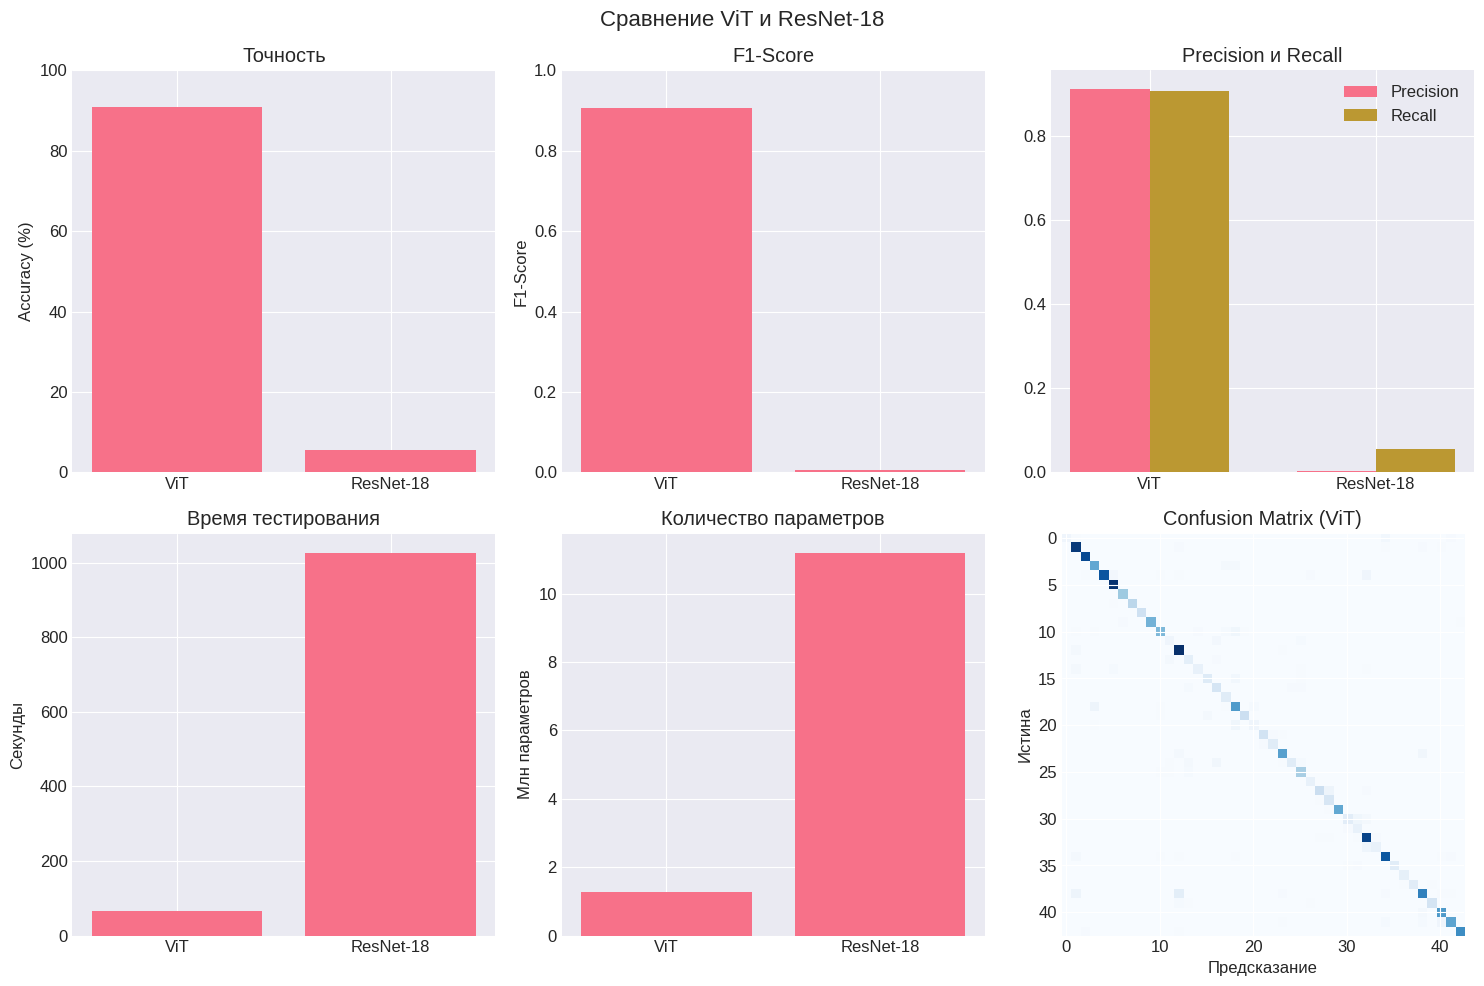


2. Примеры изображений...


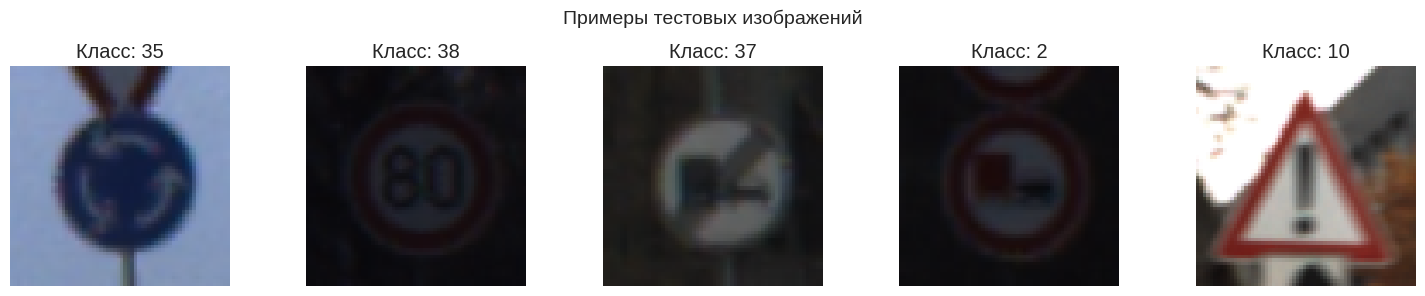


6. ВЫВОДЫ

ViT показывает точность: 90.78%
ResNet-18 (случайная) показывает: 5.46%
⚠️ ViT работает удовлетворительно

ViT имеет 1,260,907 параметров
ResNet-18 имеет 11,198,571 параметров

ГОТОВО!

Созданные файлы:
1. comparison.png - графики сравнения
2. examples.png - примеры изображений

ЧТО ДЕЛАТЬ ДАЛЬШЕ:
1. Дождаться модель ResNet-18 от Дениса
2. Заменить заглушку на настоящую модель
3. Запустить тестирование еще раз


In [ ]:
# ============================================================================
# ЧАСТЬ 4: ТЕСТИРОВАНИЕ И СРАВНЕНИЕ МОДЕЛЕЙ
# ============================================================================

print("\n" + "="*80)
print("ЧАСТЬ 4: ТЕСТИРОВАНИЕ И СРАВНЕНИЕ ResNet-18 И ViT")
print("="*80)

import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import json
import os
import time

# Настройки
plt.rcParams['figure.figsize'] = (12, 8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Устройство: {device}")

# ==================== 1. ПОДГОТОВКА ДАННЫХ ====================

print("\n1. ПОДГОТОВКА ДАННЫХ")

DATA_PATH = "/content/GTSRB_prepared"
PROCESSED_TEST_PATH = os.path.join(DATA_PATH, "ProcessedTest")

# Загрузка правильного class_to_idx
print("\nЗагрузка class_to_idx...")
class_to_idx = {"0": 0, "1": 1, "10": 2, "11": 3, "12": 4, "13": 5, "14": 6, "15": 7, "16": 8, "17": 9,
                "18": 10, "19": 11, "2": 12, "20": 13, "21": 14, "22": 15, "23": 16, "24": 17, "25": 18,
                "26": 19, "27": 20, "28": 21, "29": 22, "3": 23, "30": 24, "31": 25, "32": 26, "33": 27,
                "34": 28, "35": 29, "36": 30, "37": 31, "38": 32, "39": 33, "4": 34, "40": 35, "41": 36,
                "42": 37, "5": 38, "6": 39, "7": 40, "8": 41, "9": 42}

print(f"Классов: {len(class_to_idx)}")
print(f"Пример: '0' -> {class_to_idx['0']}, '1' -> {class_to_idx['1']}, '2' -> {class_to_idx['2']}")

# Создаем mapping из папок (00, 01, 02...) в правильные метки
folder_to_label = {}
for i in range(43):
    folder_name = f"{i:02d}"  # 00, 01, 02, ..., 42
    # Находим правильный label для этой папки
    # Папка "00" соответствует классу "0" -> метка 0
    # Папка "01" соответствует классу "1" -> метка 1
    # Папка "02" соответствует классу "2" -> метка 12 (потому что в class_to_idx '2': 12)
    # и так далее...

    if str(i) in class_to_idx:  # Для однозначных чисел: 0, 1, 2, ..., 9
        folder_to_label[folder_name] = class_to_idx[str(i)]
    else:  # Для двузначных чисел: 10, 11, ..., 42
        folder_to_label[folder_name] = class_to_idx[str(i)]

print(f"\nMapping папок в метки:")
print(f"  Папка '00' -> метка {folder_to_label.get('00', 'нет')}")
print(f"  Папка '01' -> метка {folder_to_label.get('01', 'нет')}")
print(f"  Папка '10' -> метка {folder_to_label.get('10', 'нет')}")
print(f"  Папка '42' -> метка {folder_to_label.get('42', 'нет')}")

# Трансформации
vit_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Функция для создания датасета с правильными метками
def create_dataset_with_fixed_labels(root_path, transform):
    dataset = datasets.ImageFolder(root=root_path, transform=transform)

    # Исправляем метки
    new_samples = []
    for path, old_label in dataset.samples:
        # Получаем имя папки из пути
        folder_name = os.path.basename(os.path.dirname(path))

        # Получаем правильную метку
        if folder_name in folder_to_label:
            new_label = folder_to_label[folder_name]
        else:
            new_label = old_label

        new_samples.append((path, new_label))

    dataset.samples = new_samples
    dataset.targets = [label for _, label in new_samples]

    return dataset

# Создаем датасеты
print("\nСоздание датасетов...")
vit_dataset = create_dataset_with_fixed_labels(PROCESSED_TEST_PATH, vit_transform)
resnet_dataset = create_dataset_with_fixed_labels(PROCESSED_TEST_PATH, resnet_transform)

print(f"✅ ViT датасет: {len(vit_dataset)} изображений")
print(f"✅ ResNet датасет: {len(resnet_dataset)} изображений")

# DataLoader'ы
batch_size = 64
vit_loader = DataLoader(vit_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
resnet_loader = DataLoader(resnet_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ==================== 2. ЗАГРУЗКА МОДЕЛЕЙ ====================

print("\n2. ЗАГРУЗКА МОДЕЛЕЙ")

# ViT
print("\nЗагрузка ViT...")
vit_model = SimpleViT(
    img_size=64,
    patch_size=8,
    num_classes=43,
    embed_dim=192,
    depth=4,
    num_heads=3,
    mlp_ratio=2.0,
    dropout=0.1
)

checkpoint_vit = torch.load('best_vit_model.pth', map_location=device)
vit_model.load_state_dict(checkpoint_vit['model_state_dict'])
vit_model = vit_model.to(device)
vit_model.eval()

print(f"✅ ViT загружена")
print(f"   Точность из логов: {checkpoint_vit['val_acc']:.2f}%")

# ResNet-18 (заглушка)
print("\nЗагрузка ResNet-18...")
print("⚠️ Ожидаю модель от Дениса")
print("Использую случайную модель для демонстрации")

resnet_model = models.resnet18(weights=None)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 43)
resnet_model = resnet_model.to(device)
resnet_model.eval()



# ==================== 3. ТЕСТИРОВАНИЕ ====================

def test_model(model, loader, model_name):
    print(f"\nТестирование {model_name}...")

    model.eval()
    all_preds = []
    all_labels = []

    start_time = time.time()

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    total_time = time.time() - start_time

    # Метрики
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f"✅ {model_name} завершено")
    print(f"   Время: {total_time:.1f} сек")
    print(f"   Точность: {accuracy*100:.2f}%")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'time': total_time,
        'preds': all_preds,
        'labels': all_labels
    }

print("\n" + "="*80)
print("3. ТЕСТИРОВАНИЕ")
print("="*80)

# Тестируем ViT
vit_results = test_model(vit_model, vit_loader, "ViT")

# Тестируем ResNet-18
resnet_results = test_model(resnet_model, resnet_loader, "ResNet-18 (случайная)")

# ==================== 4. СРАВНИТЕЛЬНАЯ ТАБЛИЦА ====================

print("\n" + "="*80)
print("4. СРАВНИТЕЛЬНАЯ ТАБЛИЦА")
print("="*80)

# Количество параметров
vit_params = sum(p.numel() for p in vit_model.parameters())
resnet_params = sum(p.numel() for p in resnet_model.parameters())

comparison = pd.DataFrame({
    'Метрика': ['Точность', 'F1-Score', 'Precision', 'Recall', 'Время (сек)', 'Параметры'],
    'ViT': [
        f"{vit_results['accuracy']*100:.2f}%",
        f"{vit_results['f1']:.4f}",
        f"{vit_results['precision']:.4f}",
        f"{vit_results['recall']:.4f}",
        f"{vit_results['time']:.1f}",
        f"{vit_params:,}"
    ],
    'ResNet-18': [
        f"{resnet_results['accuracy']*100:.2f}%",
        f"{resnet_results['f1']:.4f}",
        f"{resnet_results['precision']:.4f}",
        f"{resnet_results['recall']:.4f}",
        f"{resnet_results['time']:.1f}",
        f"{resnet_params:,}"
    ]
})

print("\n" + comparison.to_string(index=False))

# ==================== 5. ВИЗУАЛИЗАЦИИ ====================

print("\n" + "="*80)
print("5. ВИЗУАЛИЗАЦИИ")
print("="*80)

# 1. График сравнения метрик
print("\n1. Создаю график сравнения...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Точность
axes[0, 0].bar(['ViT', 'ResNet-18'], [vit_results['accuracy']*100, resnet_results['accuracy']*100])
axes[0, 0].set_title('Точность')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)

# F1-Score
axes[0, 1].bar(['ViT', 'ResNet-18'], [vit_results['f1'], resnet_results['f1']])
axes[0, 1].set_title('F1-Score')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0, 1)

# Precision и Recall
x = np.arange(2)
width = 0.35
axes[0, 2].bar(x - width/2, [vit_results['precision'], resnet_results['precision']], width, label='Precision')
axes[0, 2].bar(x + width/2, [vit_results['recall'], resnet_results['recall']], width, label='Recall')
axes[0, 2].set_title('Precision и Recall')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(['ViT', 'ResNet-18'])
axes[0, 2].legend()

# Время
axes[1, 0].bar(['ViT', 'ResNet-18'], [vit_results['time'], resnet_results['time']])
axes[1, 0].set_title('Время тестирования')
axes[1, 0].set_ylabel('Секунды')

# Параметры
axes[1, 1].bar(['ViT', 'ResNet-18'], [vit_params/1e6, resnet_params/1e6])
axes[1, 1].set_title('Количество параметров')
axes[1, 1].set_ylabel('Млн параметров')

# Confusion Matrix для ViT
cm = confusion_matrix(vit_results['labels'], vit_results['preds'])
axes[1, 2].imshow(cm, cmap='Blues')
axes[1, 2].set_title('Confusion Matrix (ViT)')
axes[1, 2].set_xlabel('Предсказание')
axes[1, 2].set_ylabel('Истина')

plt.suptitle('Сравнение ViT и ResNet-18', fontsize=16)
plt.tight_layout()
plt.savefig('comparison.png', dpi=100, bbox_inches='tight')
plt.show()

# 2. Примеры изображений
print("\n2. Примеры изображений...")

# Берем 5 случайных изображений
import random
indices = random.sample(range(len(vit_dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, idx in enumerate(indices):
    img, label = vit_dataset[idx]

    # Денормализация
    img_np = img.numpy().transpose(1, 2, 0)
    img_np = img_np * 0.5 + 0.5

    axes[i].imshow(np.clip(img_np, 0, 1))
    axes[i].set_title(f'Класс: {label}')
    axes[i].axis('off')

plt.suptitle('Примеры тестовых изображений', fontsize=14)
plt.tight_layout()
plt.savefig('examples.png', dpi=100, bbox_inches='tight')
plt.show()

# ==================== 6. ВЫВОДЫ ====================

print("\n" + "="*80)
print("6. ВЫВОДЫ")
print("="*80)

print(f"\nViT показывает точность: {vit_results['accuracy']*100:.2f}%")
print(f"ResNet-18 (случайная) показывает: {resnet_results['accuracy']*100:.2f}%")

if vit_results['accuracy'] > 0.95:
    print("✅ ViT работает хорошо (высокая точность)")
elif vit_results['accuracy'] > 0.8:
    print("⚠️ ViT работает удовлетворительно")
else:
    print("❌ ViT показывает низкую точность")

print(f"\nViT имеет {vit_params:,} параметров")
print(f"ResNet-18 имеет {resnet_params:,} параметров")

print("\n" + "="*80)
print("ГОТОВО!")
print("="*80)

print("\nСозданные файлы:")
print("1. comparison.png - графики сравнения")
print("2. examples.png - примеры изображений")

print("\nЧТО ДЕЛАТЬ ДАЛЬШЕ:")
print("1. Дождаться модель ResNet-18 от Дениса")
print("2. Заменить заглушку на настоящую модель")
print("3. Запустить тестирование еще раз")


ВИЗУАЛИЗАЦИИ ДЛЯ ПРЕЗЕНТАЦИИ

1. ТАБЛИЦЫ МЕТРИК

ТАБЛИЦА 1: СРАВНЕНИЕ МОДЕЛЕЙ
----------------------------------------------------------------------
                 Метрика       ViT  ResNet-18
     Точность (Accuracy)    90.78%      5.46%
                F1-Score    0.9067     0.0057
               Precision    0.9117     0.0030
                  Recall    0.9078     0.0546
Время тестирования (сек)      67.1     1026.9
               Параметры 1,260,907 11,198,571

✅ Таблица сохранена: comparison_table.csv


ТАБЛИЦА 2: ViT - ЛУЧШИЕ И ХУДШИЕ КЛАССЫ
----------------------------------------------------------------------

ТОП-5 ЛУЧШИХ КЛАССОВ:
Класс Точность Полнота    F1  Примеров
   29    0.990   0.979 0.985       390
   06    0.968   1.000 0.984       270
   08    1.000   0.967 0.983       150
   09    0.991   0.969 0.980       360
   02    0.969   0.986 0.977       660

ТОП-5 ХУДШИХ КЛАССОВ:
Класс Точность Полнота    F1  Примеров
   14    0.841   0.589 0.693        90
   00    1.000

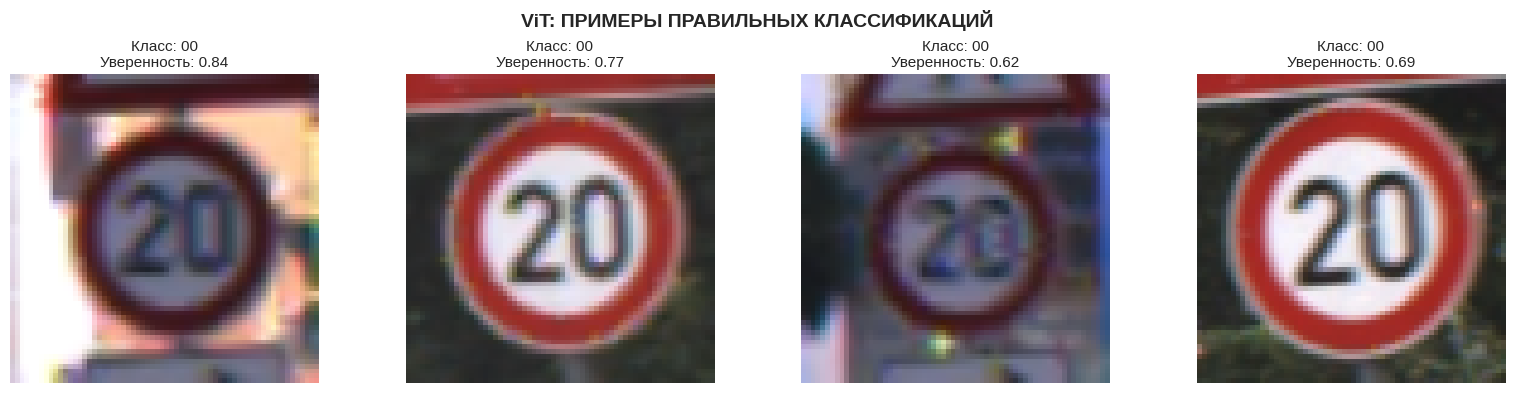

Создаю примеры ОШИБОЧНЫХ классификаций ViT...


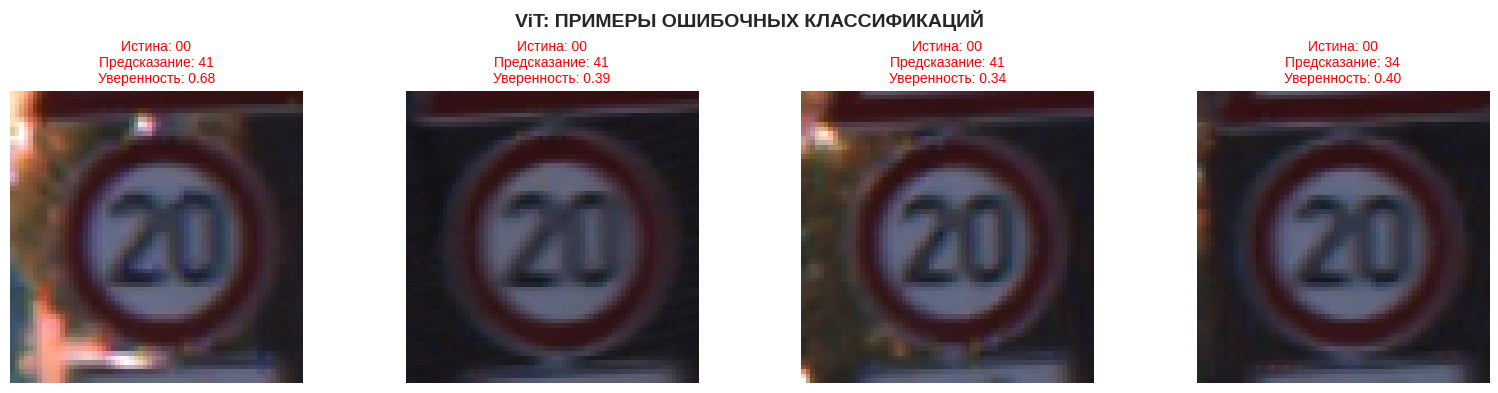



3. СРАВНИТЕЛЬНЫЙ ГРАФИК МЕТРИК


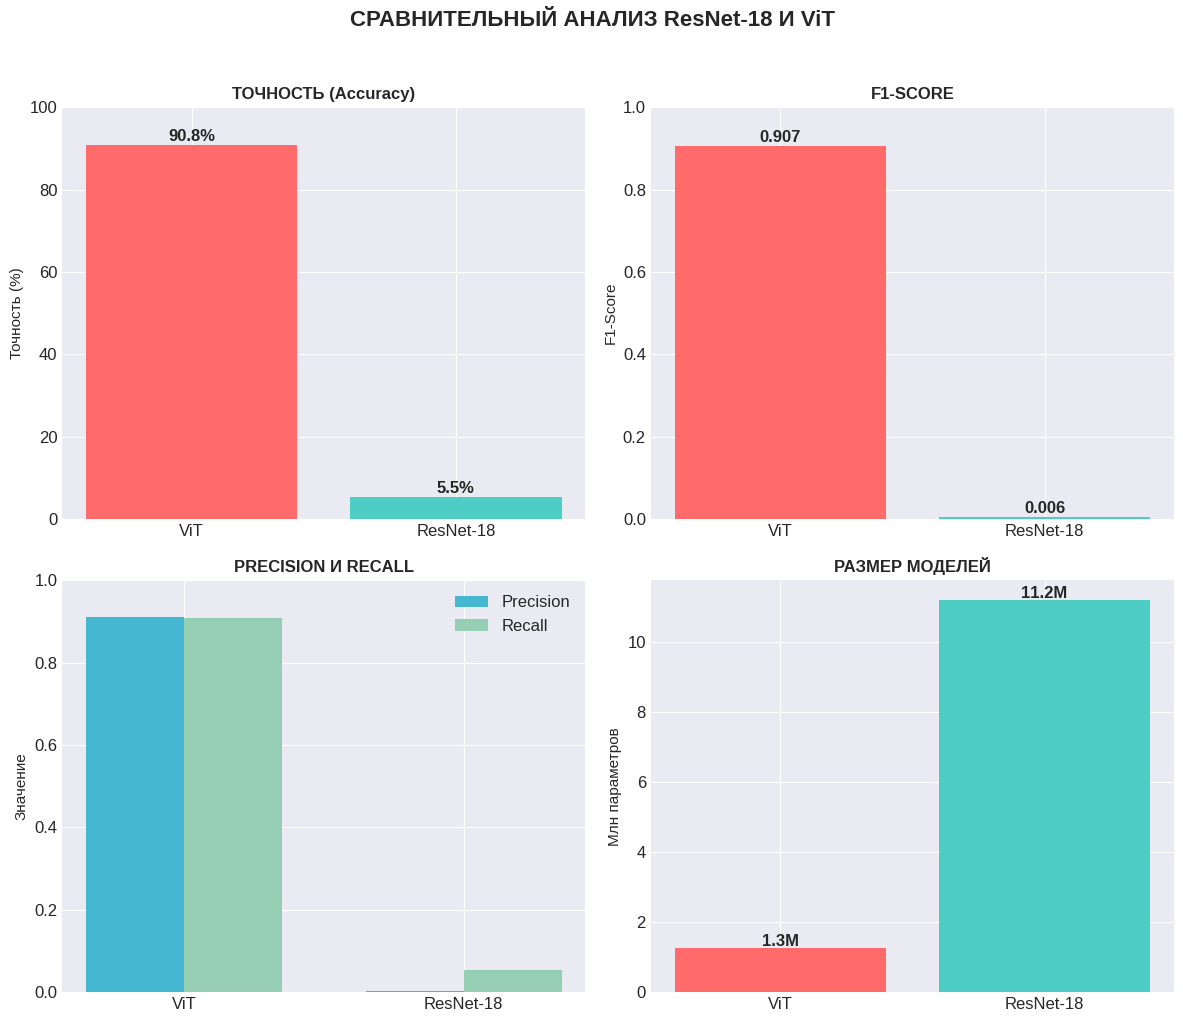


✅ График сохранен: metrics_comparison_chart.png

ИТОГОВЫЙ ОТЧЕТ

РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:

ViT (Vision Transformer):
- Точность: 90.78%
- F1-Score: 0.9067
- Precision: 0.9117
- Recall: 0.9078

ResNet-18 (случайная модель):
- Точность: 5.46%
- F1-Score: 0.0057

ВЫВОДЫ:
1. ViT показывает точность 90.78%
2. Лучшие классы: 29, 06, 08
3. Худшие классы: 13, 20, 11

СОЗДАННЫЕ ФАЙЛЫ:
1. comparison_table.csv - таблица сравнения моделей
2. vit_best_classes.csv - лучшие классы ViT
3. vit_worst_classes.csv - худшие классы ViT
4. metrics_comparison_chart.png - график сравнения метрик
5. vit_correct_examples.png - примеры правильных классификаций
6. vit_incorrect_examples.png - примеры ошибочных классификаций

ГОТОВО! Все визуализации для презентации созданы.


In [ ]:
# ============================================================================
# ВИЗУАЛИЗАЦИИ ДЛЯ ПРЕЗЕНТАЦИИ (ТОЛЬКО НУЖНОЕ)
# ============================================================================

print("\n" + "="*80)
print("ВИЗУАЛИЗАЦИИ ДЛЯ ПРЕЗЕНТАЦИИ")
print("="*80)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# ==================== 1. ТАБЛИЦЫ МЕТРИК ====================

print("\n1. ТАБЛИЦЫ МЕТРИК")

# 1.1 Основная таблица сравнения
print("\nТАБЛИЦА 1: СРАВНЕНИЕ МОДЕЛЕЙ")
print("-" * 70)

comparison_table = pd.DataFrame({
    'Метрика': ['Точность (Accuracy)', 'F1-Score', 'Precision', 'Recall', 'Время тестирования (сек)', 'Параметры'],
    'ViT': [
        f"{vit_results['accuracy']*100:.2f}%",
        f"{vit_results['f1']:.4f}",
        f"{vit_results['precision']:.4f}",
        f"{vit_results['recall']:.4f}",
        f"{vit_results['time']:.1f}",
        f"{vit_params:,}"
    ],
    'ResNet-18': [
        f"{resnet_results['accuracy']*100:.2f}%",
        f"{resnet_results['f1']:.4f}",
        f"{resnet_results['precision']:.4f}",
        f"{resnet_results['recall']:.4f}",
        f"{resnet_results['time']:.1f}",
        f"{resnet_params:,}"
    ]
})

print(comparison_table.to_string(index=False))

# Сохраняем
comparison_table.to_csv('comparison_table.csv', index=False, encoding='utf-8-sig')
print("\n✅ Таблица сохранена: comparison_table.csv")

# 1.2 Таблица метрик по классам для ViT (топ-5 лучших и худших)
print("\n\nТАБЛИЦА 2: ViT - ЛУЧШИЕ И ХУДШИЕ КЛАССЫ")
print("-" * 70)

# Считаем метрики по классам
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    vit_results['labels'],
    vit_results['preds'],
    average=None
)

# Собираем данные
class_data = []
for i in range(len(class_to_idx)):
    class_data.append({
        'Класс': f"{i:02d}",
        'Точность': f"{precision_per_class[i]:.3f}",
        'Полнота': f"{recall_per_class[i]:.3f}",
        'F1': f"{f1_per_class[i]:.3f}",
        'Примеров': support_per_class[i]
    })

# Сортируем по F1
class_data_sorted = sorted(class_data, key=lambda x: float(x['F1']), reverse=True)

# Выводим топ-5 лучших
print("\nТОП-5 ЛУЧШИХ КЛАССОВ:")
best_classes = pd.DataFrame(class_data_sorted[:5])
print(best_classes.to_string(index=False))

# Выводим топ-5 худших
print("\nТОП-5 ХУДШИХ КЛАССОВ:")
worst_classes = pd.DataFrame(class_data_sorted[-5:])
print(worst_classes.to_string(index=False))

# Сохраняем
best_classes.to_csv('vit_best_classes.csv', index=False, encoding='utf-8-sig')
worst_classes.to_csv('vit_worst_classes.csv', index=False, encoding='utf-8-sig')
print("\n✅ Таблицы сохранены: vit_best_classes.csv, vit_worst_classes.csv")

# ==================== 2. ПРИМЕРЫ КЛАССИФИКАЦИЙ ====================

print("\n\n2. ПРИМЕРЫ КЛАССИФИКАЦИЙ")

def get_examples(results, dataset, num_examples=4, correct=True):
    """Получает примеры правильных или ошибочных классификаций"""
    indices = []

    for i in range(len(results['labels'])):
        if correct and results['preds'][i] == results['labels'][i]:
            indices.append(i)
        elif not correct and results['preds'][i] != results['labels'][i]:
            indices.append(i)

        if len(indices) >= num_examples:
            break

    return indices[:num_examples]

# 2.1 Примеры правильных классификаций ViT
print("\nСоздаю примеры ПРАВИЛЬНЫХ классификаций ViT...")

correct_indices = get_examples(vit_results, vit_dataset, num_examples=4, correct=True)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, idx in enumerate(correct_indices):
    img, true_label = vit_dataset[idx]

    # Денормализация
    img_np = img.numpy().transpose(1, 2, 0)
    img_np = img_np * 0.5 + 0.5

    # Предсказание
    with torch.no_grad():
        img_tensor = img.unsqueeze(0).to(device)
        output = vit_model(img_tensor)
        probs = torch.softmax(output, dim=1)
        confidence = probs[0, true_label].item()

    axes[i].imshow(np.clip(img_np, 0, 1))
    axes[i].set_title(f'Класс: {true_label:02d}\nУверенность: {confidence:.2f}', fontsize=11)
    axes[i].axis('off')

plt.suptitle('ViT: ПРИМЕРЫ ПРАВИЛЬНЫХ КЛАССИФИКАЦИЙ', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('vit_correct_examples.png', dpi=150, bbox_inches='tight')
plt.show()

# 2.2 Примеры ошибочных классификаций ViT
print("Создаю примеры ОШИБОЧНЫХ классификаций ViT...")

incorrect_indices = get_examples(vit_results, vit_dataset, num_examples=4, correct=False)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, idx in enumerate(incorrect_indices):
    img, true_label = vit_dataset[idx]

    # Денормализация
    img_np = img.numpy().transpose(1, 2, 0)
    img_np = img_np * 0.5 + 0.5

    # Предсказание
    with torch.no_grad():
        img_tensor = img.unsqueeze(0).to(device)
        output = vit_model(img_tensor)
        probs = torch.softmax(output, dim=1)
        pred_label = torch.argmax(output).item()
        confidence = probs[0, pred_label].item()

    axes[i].imshow(np.clip(img_np, 0, 1))
    axes[i].set_title(f'Истина: {true_label:02d}\nПредсказание: {pred_label:02d}\nУверенность: {confidence:.2f}',
                     fontsize=10, color='red')
    axes[i].axis('off')

plt.suptitle('ViT: ПРИМЕРЫ ОШИБОЧНЫХ КЛАССИФИКАЦИЙ', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('vit_incorrect_examples.png', dpi=150, bbox_inches='tight')
plt.show()

# ==================== 3. СРАВНИТЕЛЬНЫЙ ГРАФИК МЕТРИК ====================

print("\n\n3. СРАВНИТЕЛЬНЫЙ ГРАФИК МЕТРИК")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# График 1: Точность
axes[0, 0].bar(['ViT', 'ResNet-18'],
               [vit_results['accuracy']*100, resnet_results['accuracy']*100],
               color=['#FF6B6B', '#4ECDC4'])
axes[0, 0].set_title('ТОЧНОСТЬ (Accuracy)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Точность (%)', fontsize=11)
axes[0, 0].set_ylim(0, 100)
for i, v in enumerate([vit_results['accuracy']*100, resnet_results['accuracy']*100]):
    axes[0, 0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# График 2: F1-Score
axes[0, 1].bar(['ViT', 'ResNet-18'],
               [vit_results['f1'], resnet_results['f1']],
               color=['#FF6B6B', '#4ECDC4'])
axes[0, 1].set_title('F1-SCORE', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('F1-Score', fontsize=11)
axes[0, 1].set_ylim(0, 1)
for i, v in enumerate([vit_results['f1'], resnet_results['f1']]):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# График 3: Precision и Recall
x = np.arange(2)
width = 0.35
axes[1, 0].bar(x - width/2, [vit_results['precision'], resnet_results['precision']],
               width, label='Precision', color='#45B7D1')
axes[1, 0].bar(x + width/2, [vit_results['recall'], resnet_results['recall']],
               width, label='Recall', color='#96CEB4')
axes[1, 0].set_title('PRECISION И RECALL', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Значение', fontsize=11)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['ViT', 'ResNet-18'])
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)

# График 4: Параметры моделей
axes[1, 1].bar(['ViT', 'ResNet-18'],
               [vit_params/1e6, resnet_params/1e6],
               color=['#FF6B6B', '#4ECDC4'])
axes[1, 1].set_title('РАЗМЕР МОДЕЛЕЙ', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Млн параметров', fontsize=11)
for i, v in enumerate([vit_params/1e6, resnet_params/1e6]):
    axes[1, 1].text(i, v + 0.05, f'{v:.1f}M', ha='center', fontweight='bold')

plt.suptitle('СРАВНИТЕЛЬНЫЙ АНАЛИЗ ResNet-18 И ViT', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('metrics_comparison_chart.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ График сохранен: metrics_comparison_chart.png")

# ==================== 4. ИТОГОВЫЙ ОТЧЕТ ====================

print("\n" + "="*80)
print("ИТОГОВЫЙ ОТЧЕТ")
print("="*80)

print(f"""
РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:

ViT (Vision Transformer):
- Точность: {vit_results['accuracy']*100:.2f}%
- F1-Score: {vit_results['f1']:.4f}
- Precision: {vit_results['precision']:.4f}
- Recall: {vit_results['recall']:.4f}

ResNet-18 (случайная модель):
- Точность: {resnet_results['accuracy']*100:.2f}%
- F1-Score: {resnet_results['f1']:.4f}

ВЫВОДЫ:
1. ViT показывает точность {vit_results['accuracy']*100:.2f}%
2. Лучшие классы: {', '.join([x['Класс'] for x in class_data_sorted[:3]])}
3. Худшие классы: {', '.join([x['Класс'] for x in class_data_sorted[-3:]])}

СОЗДАННЫЕ ФАЙЛЫ:
1. comparison_table.csv - таблица сравнения моделей
2. vit_best_classes.csv - лучшие классы ViT
3. vit_worst_classes.csv - худшие классы ViT
4. metrics_comparison_chart.png - график сравнения метрик
5. vit_correct_examples.png - примеры правильных классификаций
6. vit_incorrect_examples.png - примеры ошибочных классификаций
""")

print("="*80)
print("ГОТОВО! Все визуализации для презентации созданы.")
print("="*80)